# **Predicting Car Prices**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

## Data Preprocessing

In [2]:
df = pd.read_csv('car_prices.csv')

In [3]:
df.shape

(558837, 16)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558837 entries, 0 to 558836
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          558837 non-null  int64  
 1   make          548536 non-null  object 
 2   model         548438 non-null  object 
 3   trim          548186 non-null  object 
 4   body          545642 non-null  object 
 5   transmission  493485 non-null  object 
 6   vin           558833 non-null  object 
 7   state         558837 non-null  object 
 8   condition     547017 non-null  float64
 9   odometer      558743 non-null  float64
 10  color         558088 non-null  object 
 11  interior      558088 non-null  object 
 12  seller        558837 non-null  object 
 13  mmr           558799 non-null  float64
 14  sellingprice  558825 non-null  float64
 15  saledate      558825 non-null  object 
dtypes: float64(4), int64(1), object(11)
memory usage: 68.2+ MB


In [5]:
df.duplicated().any()

False

In [6]:
df.describe()

,year,condition,odometer,mmr,sellingprice
count,558837.000000,547017.000000,558743.000000,558799.000000,558825.000000
mean,2010.038927,30.672365,68320.017767,13769.377495,13611.358810
std,3.966864,13.402832,53398.542821,9679.967174,9749.501628
min,1982.000000,1.000000,1.000000,25.000000,1.000000
25%,2007.000000,23.000000,28371.000000,7100.000000,6900.000000
50%,2012.000000,35.000000,52254.000000,12250.000000,12100.000000
75%,2013.000000,42.000000,99109.000000,18300.000000,18200.000000
max,2015.000000,49.000000,999999.000000,182000.000000,230000.000000


In [7]:
df.isnull().sum()

year                0
make            10301
model           10399
trim            10651
body            13195
transmission    65352
vin                 4
state               0
condition       11820
odometer           94
color             749
interior          749
seller              0
mmr                38
sellingprice       12
saledate           12
dtype: int64

## Cleaning data
Replacing/removing missing data based on importance

In [8]:
df['make'] = df['make'].fillna('other')
df['model'] = df['model'].fillna('other')
df['trim'] = df['trim'].fillna('other')
df['body'] = df['body'].fillna('other')
df['transmission'] = df['transmission'].fillna('other')
df['color'] = df['color'].fillna('other')
df['interior'] = df['interior'].fillna('other')
df.drop(df[df['condition'].isna()].index,inplace=True)
df.drop(df[df['odometer'].isna()].index,inplace=True)
df.drop(df[df['mmr'].isna()].index, inplace=True)

In [9]:
df.isnull().sum()

year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
mmr             0
sellingprice    0
saledate        0
dtype: int64

## Feature Engineering
Seperating 'saledate' into month and year to get car age

In [10]:
df['saledate'] = df['saledate'].str.split(' ')
df['sale_month'] = df['saledate'].str[1]
df['sale_year'] = df['saledate'].str[3]
df['sale_year'] = pd.to_numeric(df['sale_year'])
df.drop('saledate',axis=1,inplace=True)
df['car_age'] = df['sale_year'] - df['year']
df.loc[df['car_age'] == -1, 'car_age'] = 0

In [11]:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

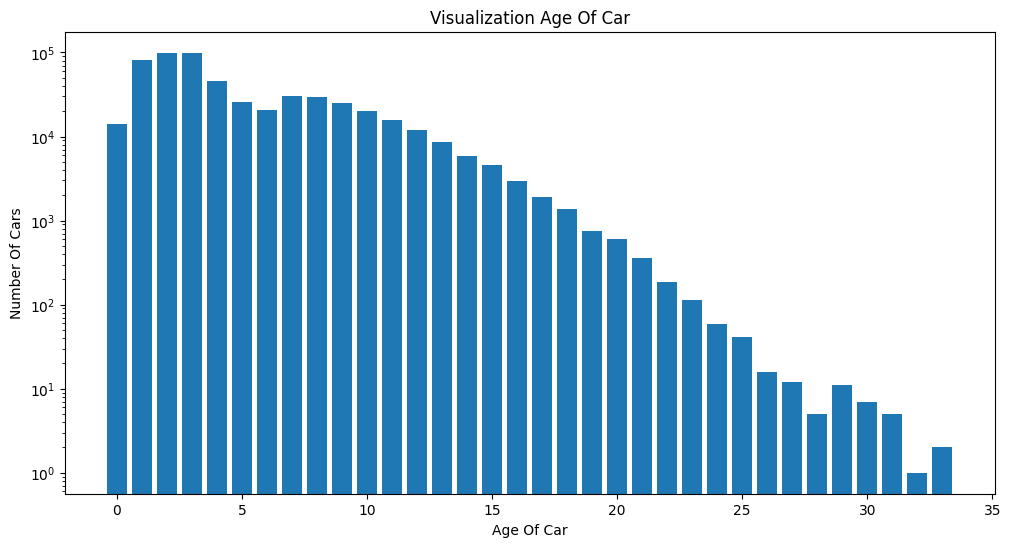

In [12]:
age_count = df.groupby('car_age',as_index=False)['year'].count()

plt.figure(figsize=(12,6))

plt.bar(x=age_count['car_age'],height=age_count['year'],log=True)
plt.xlabel('Age Of Car')
plt.ylabel('Number Of Cars')
plt.title('Visualization Age Of Car')
plt.show()

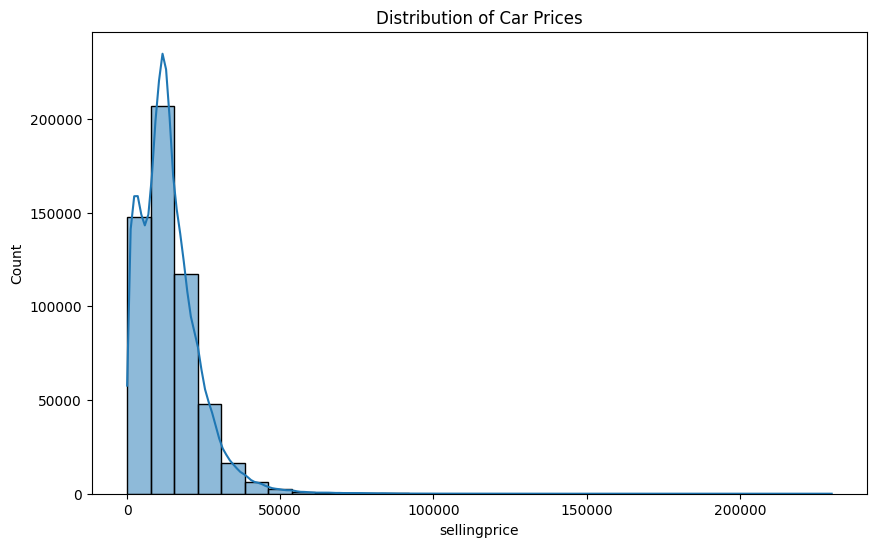

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(df['sellingprice'], bins=30, kde=True)
plt.title('Distribution of Car Prices')
plt.show()

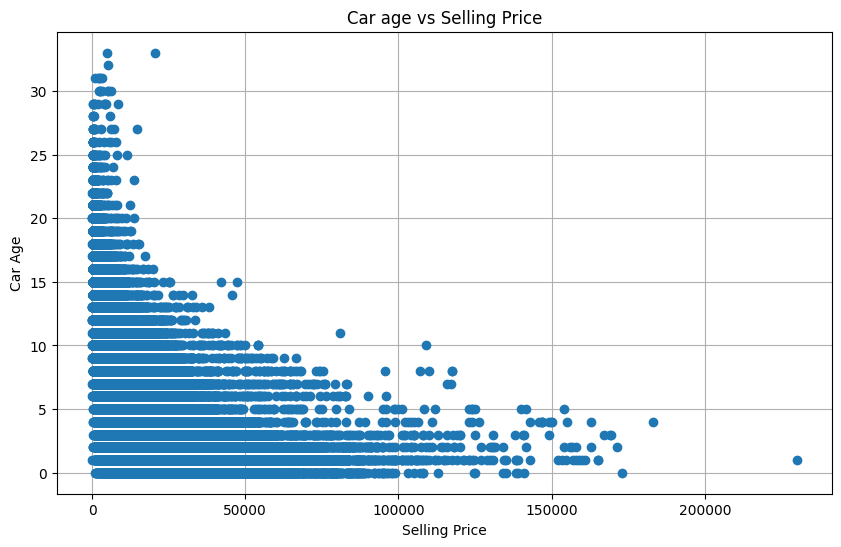

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(df['sellingprice'],df['car_age'],'o')
plt.xlabel('Selling Price')
plt.ylabel('Car Age')
plt.title('Car age vs Selling Price')
plt.grid(True)
plt.show()

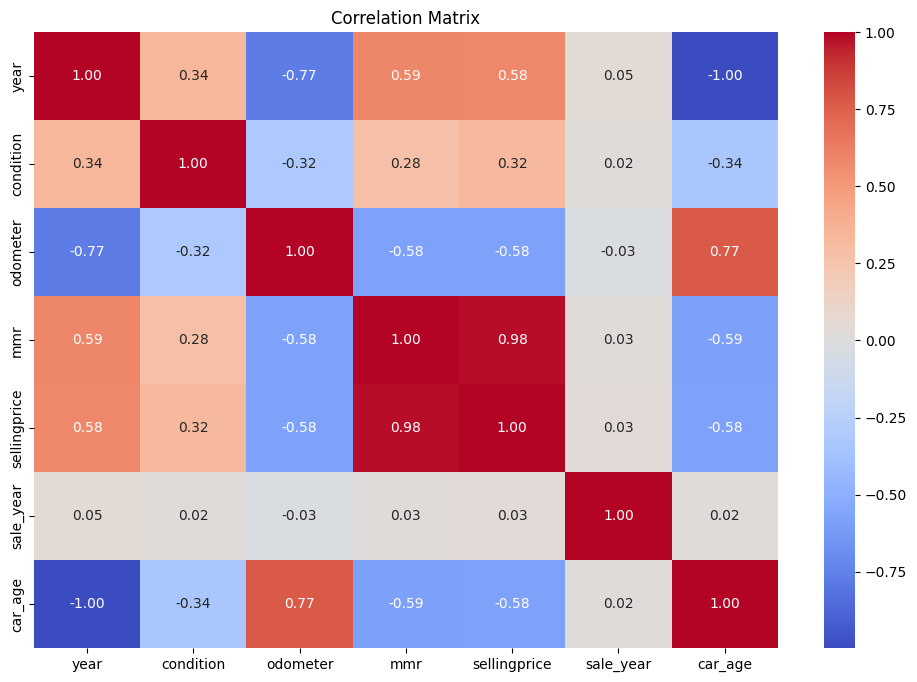

In [15]:
plt.figure(figsize=(12, 8))
sns.heatmap(df[numeric_columns].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

## Linear Regression

In [16]:
X = df[['year','car_age','condition','odometer']]
y = df['sellingprice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [17]:
y_pred = model.predict(X_test)

In [18]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Absolute Error: 5239.295329104279
Mean Squared Error: 57769583.38310904
R-squared: 0.3917852722202503


## Random Forest Regression

In [19]:
X_rf = df[numeric_columns].drop(['sellingprice'], axis=1)
y_rf = df['sellingprice']
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("Train set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

Train set: (350064, 6) (350064,)
Validation set: (87516, 6) (87516,)
Test set: (109396, 6) (109396,)


In [20]:
rf_model.fit(X_train, y_train)
rf_val_pred = rf_model.predict(X_val)

In [21]:
rf_val_mae = mean_absolute_error(y_val, rf_val_pred)
rf_val_mse = mean_squared_error(y_val, rf_val_pred)
rf_val_r2 = r2_score(y_val, rf_val_pred)

print(f'Mean Absolute Error: {rf_val_mae}')
print(f'Mean Squared Error: {rf_val_mse}')
print(f'R-squared: {rf_val_r2}')

Mean Absolute Error: 1013.1868360574609
Mean Squared Error: 2542732.1322067776
R-squared: 0.9733377702728558


In [22]:
rf_pred = rf_model.predict(X_test)
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_mse = mean_squared_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)

print(f'Mean Absolute Error: {rf_mae}')
print(f'Mean Squared Error: {rf_mse}')
print(f'R-squared: {rf_r2}')

Mean Absolute Error: 1014.4060225998513
Mean Squared Error: 2521692.18458143
R-squared: 0.9734509020877247


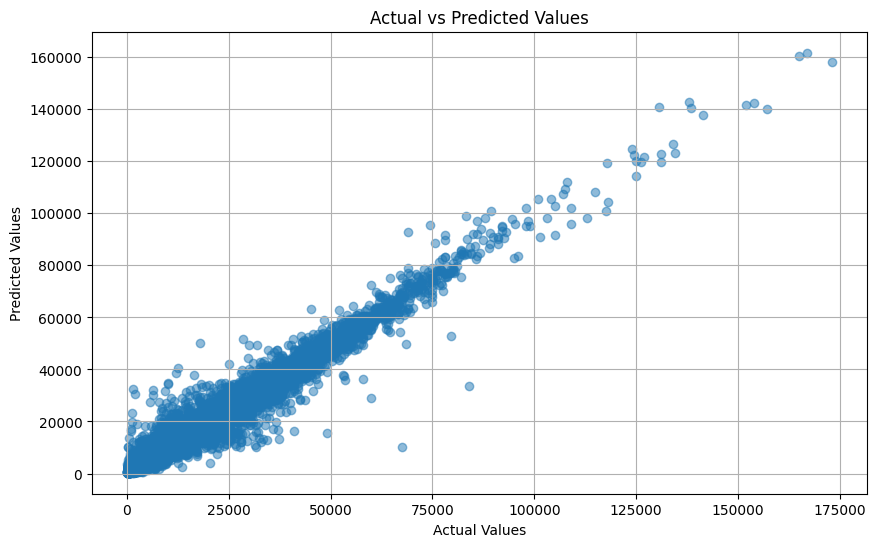

In [23]:
plt.figure(figsize=(10, 6))

plt.scatter(y_test, rf_pred, alpha=0.5)
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

## Conclusion

The main features that affected the model were the year, car age, condition, and odometer reading. Using the Random Forest Regression gave me much stronger results than the linear regression, though I believe the main reason for this was that it used the mmr feature from the data, which I had ommited from the linear regression for testing purposes.